In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pylab 
from scipy.stats import f_oneway, ttest_ind

In [35]:
mesorregioes = pd.read_csv("src\mesorregios.csv")
dados_completos = pd.read_csv("src\dados_completos.csv")

Faço a divisão trimestral dos dados

In [36]:
dados_completos['Data'] = pd.to_datetime(dados_completos['Data'])

def get_trimestre(data):
    mes = data.month
    if 1 <= mes <= 3:
        return '1º Trimestre'
    elif 4 <= mes <= 6:
        return '2º Trimestre'
    elif 7 <= mes <= 9:
        return '3º Trimestre'
    else:  # 10 <= mes <= 12
        return '4º Trimestre'

dados_completos['Trimestre'] = dados_completos['Data'].apply(get_trimestre)

ordem_trimestres = ['1º Trimestre', '2º Trimestre', '3º Trimestre', '4º Trimestre']

Dicionario com os meses do ano

In [37]:
nomes_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

In [38]:
mesorregioes = dados_completos['Mesorregião'].unique()

Pego só os meses dos nossos dados pois é o que iremos avaliar

In [39]:
dados_completos['Mes'] = dados_completos['Data'].dt.month

## Distribuição por Mesorregião

O boxplot mostra a distribuição da precipitação por mesorregião

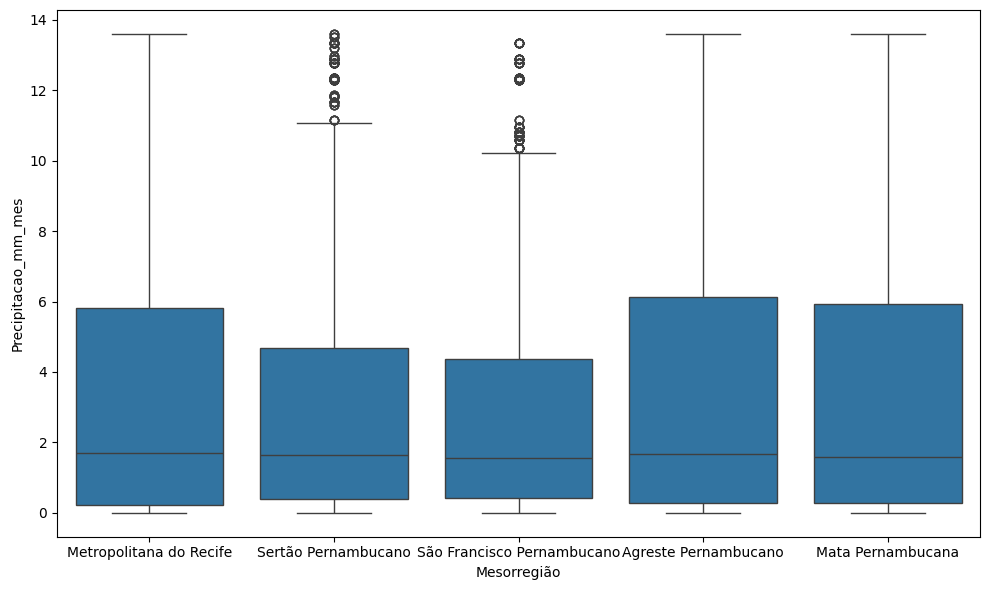

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_completos, x="Mesorregião", y="Precipitacao_mm_mes")
plt.tight_layout()
plt.show()

### Trimestre

O boxplot mostra a distribuição da precipitação por mesorregião a cada trimestre

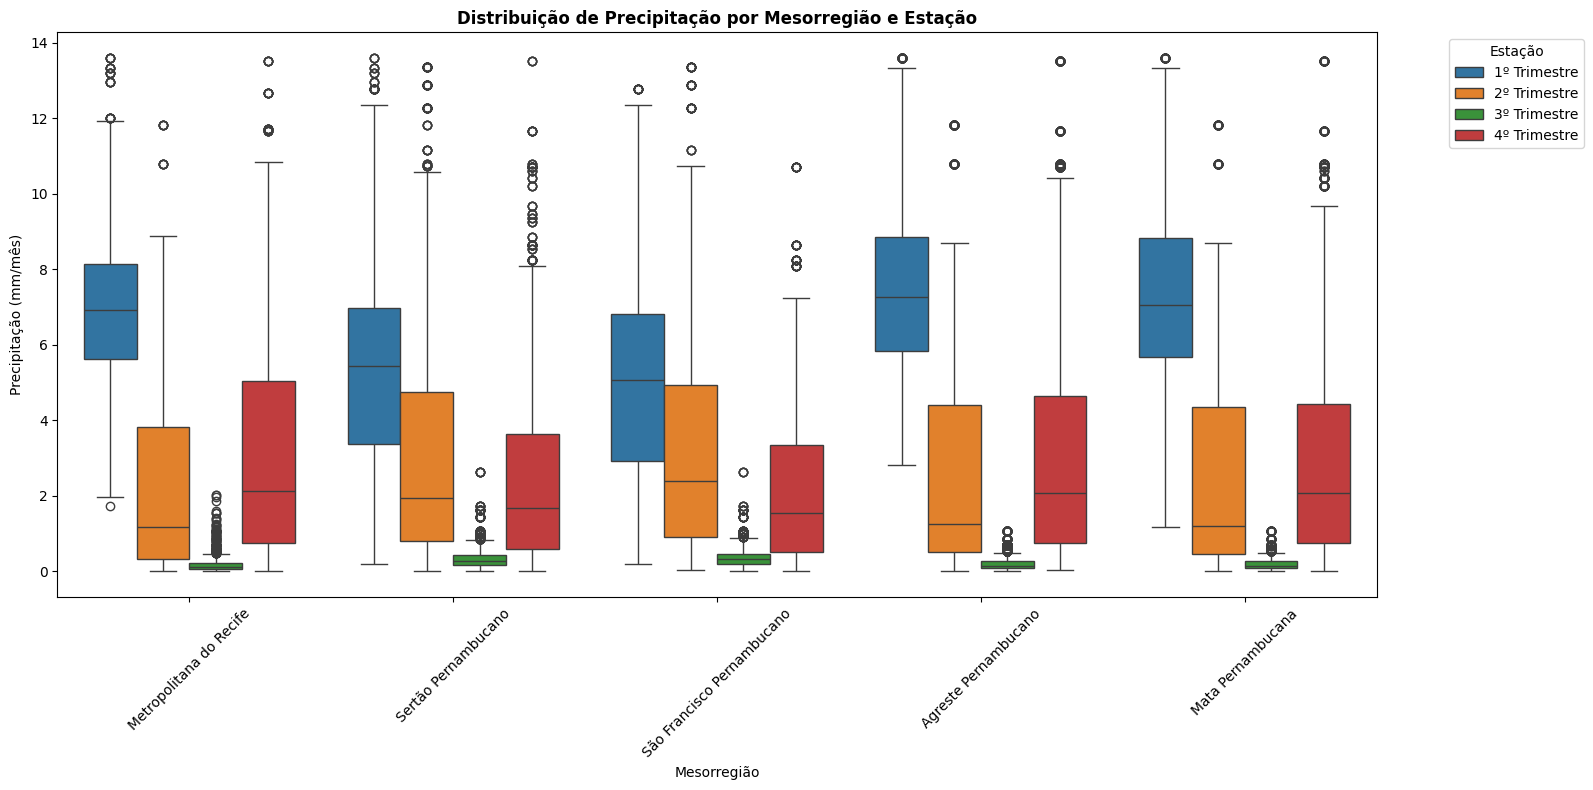

In [41]:
dados_completos['Trimestre'] = dados_completos['Data'].apply(get_trimestre)

plt.figure(figsize=(16, 8))
sns.boxplot(data=dados_completos, x="Mesorregião", y="Precipitacao_mm_mes", hue="Trimestre")
plt.title('Distribuição de Precipitação por Mesorregião e Estação', fontweight='bold')
plt.xlabel('Mesorregião')
plt.ylabel('Precipitação (mm/mês)')
plt.legend(title='Estação', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### por mês

Gráfico de linha mostrando a precipitação mensal por mesorregião

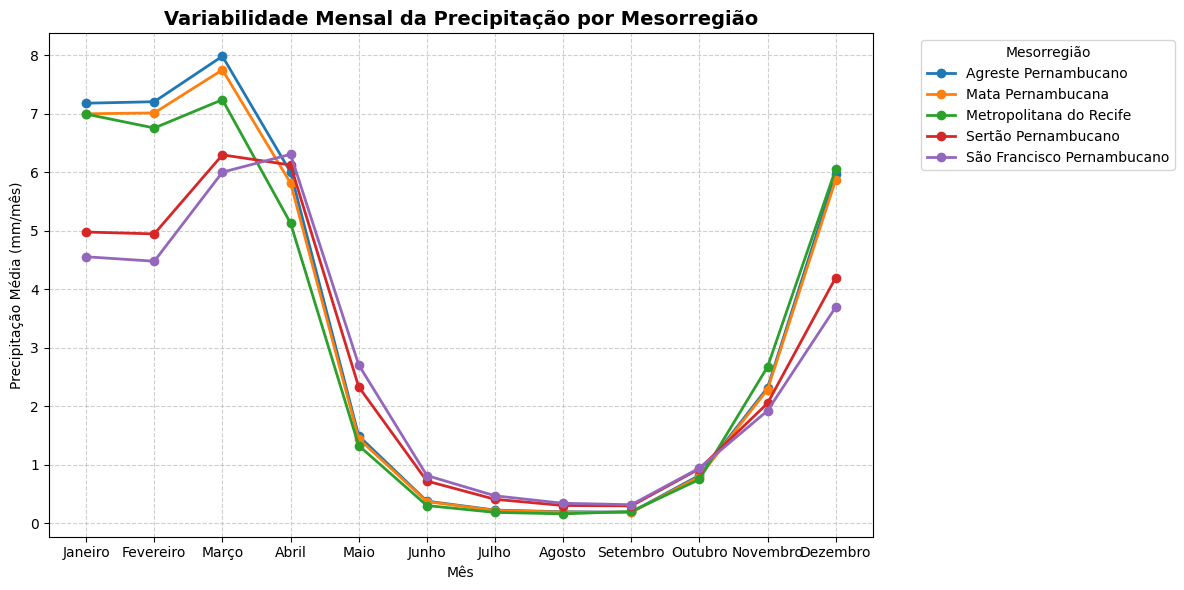

In [42]:
media_mensal = (
    dados_completos.groupby(['Mesorregião', 'Mes'])['Precipitacao_mm_mes']
    .mean()
    .reset_index()
)

nomes_lista = [nomes_meses[i] for i in range(1, 13)]

plt.figure(figsize=(12, 6))
for mesorregiao, grupo in media_mensal.groupby('Mesorregião'):
    grupo = grupo.sort_values('Mes')
    plt.plot(grupo['Mes'], grupo['Precipitacao_mm_mes'], 
             marker='o', linewidth=2, markersize=6, label=mesorregiao)

plt.title('Variabilidade Mensal da Precipitação por Mesorregião', fontsize=14, fontweight='bold')
plt.xlabel('Mês')
plt.ylabel('Precipitação Média (mm/mês)')
plt.xticks(range(1, 13),nomes_lista)
plt.legend(title='Mesorregião', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Frequência por Mesorregião

Função para classificação das chuvas

In [43]:
def classificar_chuva(valor):
    if pd.isna(valor):
        return 'Dado_Faltante'
    elif valor < 0:
        return 'Valor_Invalido'
    elif valor < 0.1:
        return 'sem_chuva'
    elif valor < 2.5:
        return 'Light'
    elif valor < 10.0:
        return 'Moderate'
    elif valor < 50.0:
        return 'Heavy'
    else: 
        return 'Violent'

Classificação do tipo de chuva que cada mesorregião tem frequência

In [44]:
dados_completos['Categoria_Chuva'] = dados_completos['Precipitacao_mm_mes'].apply(classificar_chuva)

freq_absoluta = pd.crosstab( 
    dados_completos['Mesorregião'], 
    dados_completos['Categoria_Chuva'], 
    margins=True, 
    margins_name='TOTAL' 
) 

freq_absoluta

Categoria_Chuva,Heavy,Light,Moderate,sem_chuva,TOTAL
Mesorregião,,,,,
Agreste Pernambucano,1917,18318,16401,3124,39760
Mata Pernambucana,1092,11088,9852,2048,24080
Metropolitana do Recife,258,3511,3601,1030,8400
Sertão Pernambucano,514,12082,9429,935,22960
São Francisco Pernambucano,162,4682,3383,173,8400
TOTAL,3943,49681,42666,7310,103600


In [45]:
freq_relativa = pd.crosstab(
    dados_completos['Mesorregião'], 
    dados_completos['Categoria_Chuva'],
    normalize='index'
) * 100

freq_relativa

Categoria_Chuva,Heavy,Light,Moderate,sem_chuva
Mesorregião,,,,
Agreste Pernambucano,4.821429,46.071429,41.250000,7.857143
Mata Pernambucana,4.534884,46.046512,40.913621,8.504983
Metropolitana do Recife,3.071429,41.797619,42.869048,12.261905
Sertão Pernambucano,2.238676,52.621951,41.067073,4.072300
São Francisco Pernambucano,1.928571,55.738095,40.273810,2.059524


plot da distribuição relativa da mesorregião

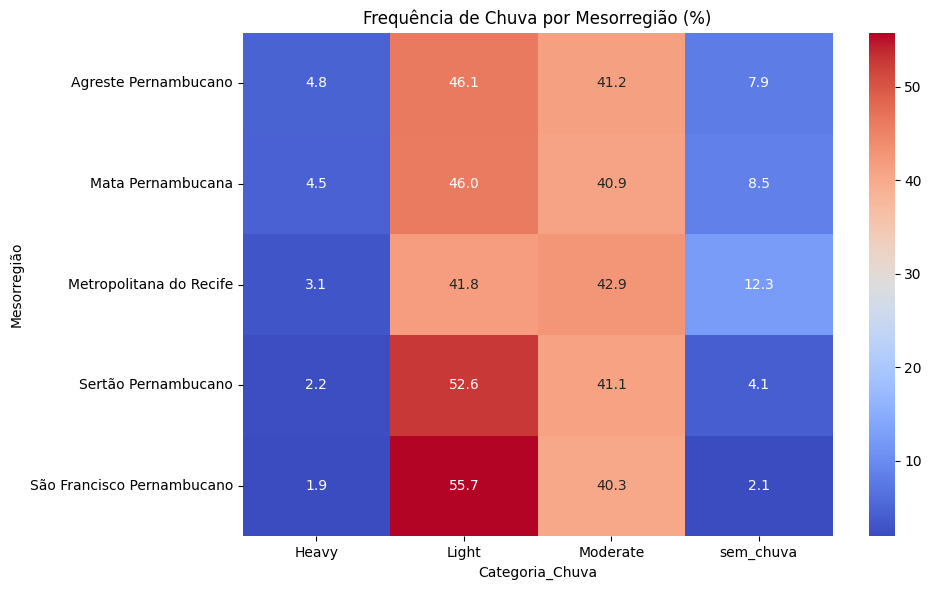

In [46]:
plt.figure(figsize=(10, 6))
sns.heatmap(freq_relativa, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Frequência de Chuva por Mesorregião (%)')
plt.tight_layout()
plt.show()

### Trimestre

Classificação do tipo de chuva que cada mesorregião tem frequência a cada trimestre

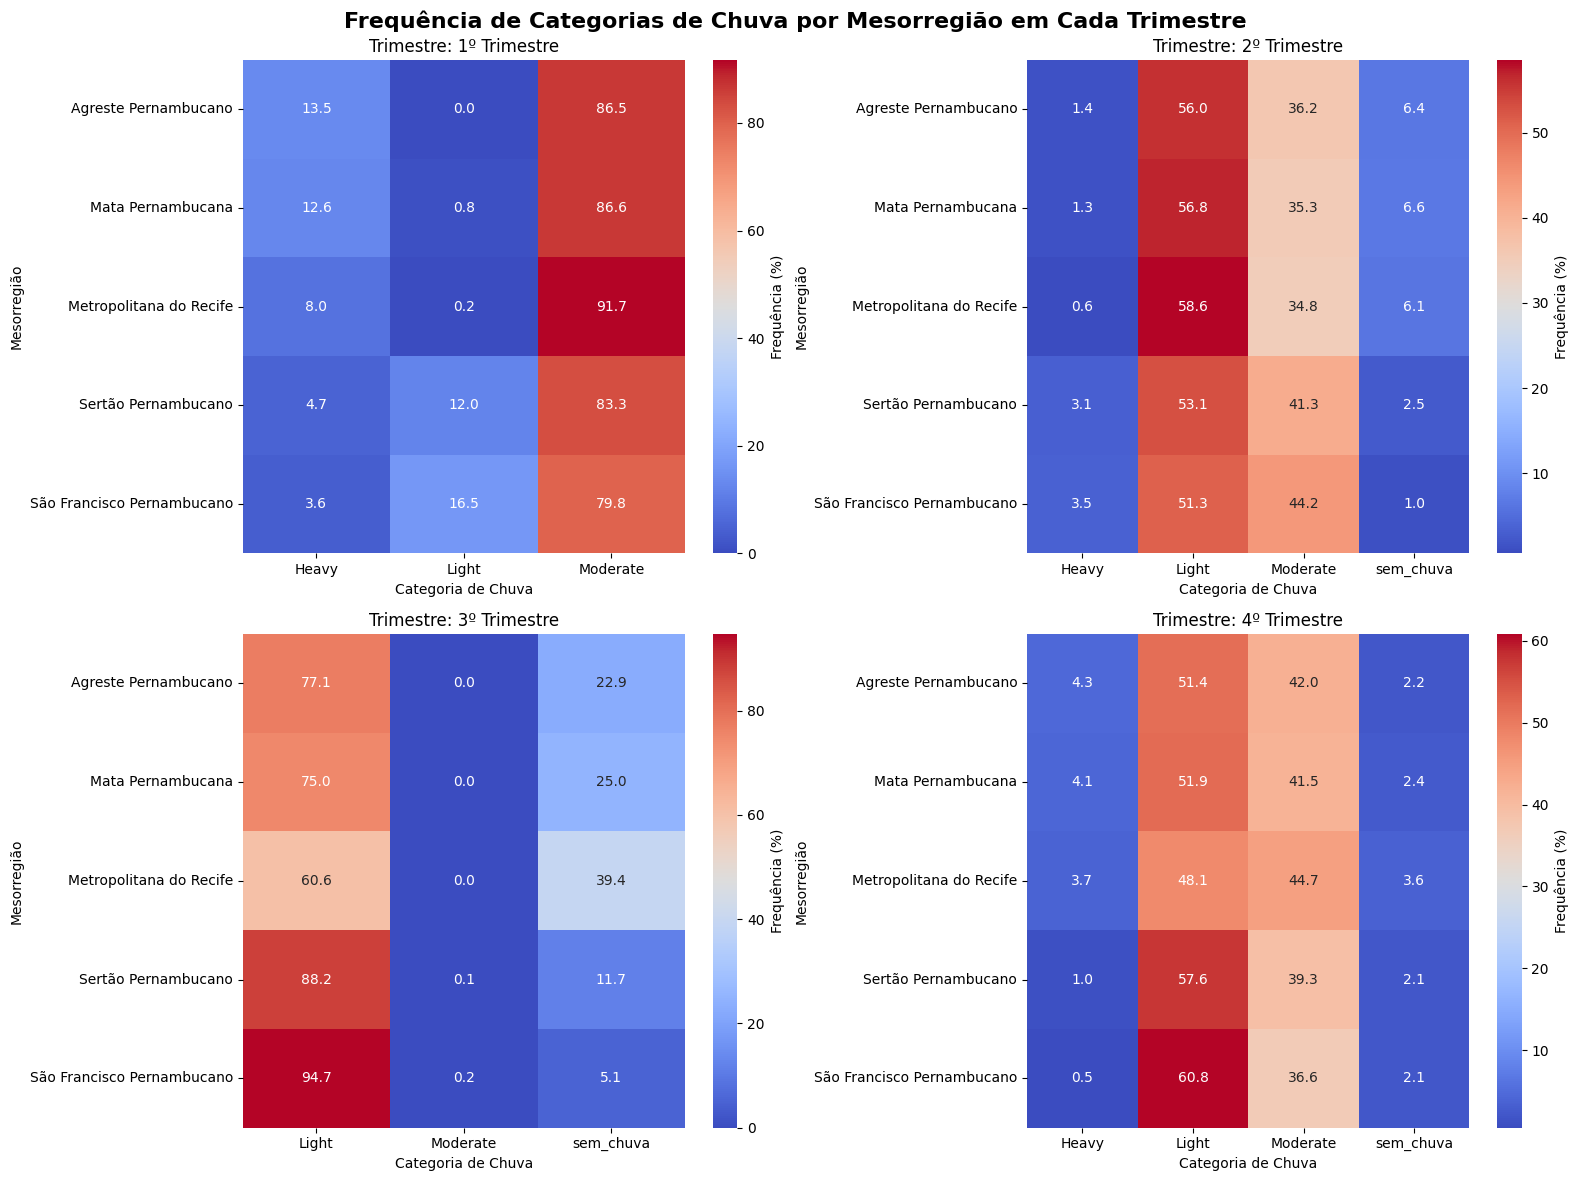

In [47]:
estacoes = dados_completos['Trimestre'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, trimestre in enumerate(estacoes):
    dados_trimestre = dados_completos[dados_completos['Trimestre'] == trimestre]
    
    freq_relativa = pd.crosstab(
        dados_trimestre['Mesorregião'], 
        dados_trimestre['Categoria_Chuva'],
        normalize='index'
    ) * 100
    
    sns.heatmap(freq_relativa, annot=True, fmt='.1f', cmap='coolwarm', 
                cbar_kws={'label': 'Frequência (%)'}, ax=axes[i])
    axes[i].set_title(f'Trimestre: {trimestre}')
    axes[i].set_xlabel('Categoria de Chuva')
    axes[i].set_ylabel('Mesorregião')

plt.suptitle('Frequência de Categorias de Chuva por Mesorregião em Cada Trimestre', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### mês

Classificação do tipo de chuva que cada mesorregião tem frequência a cada mês

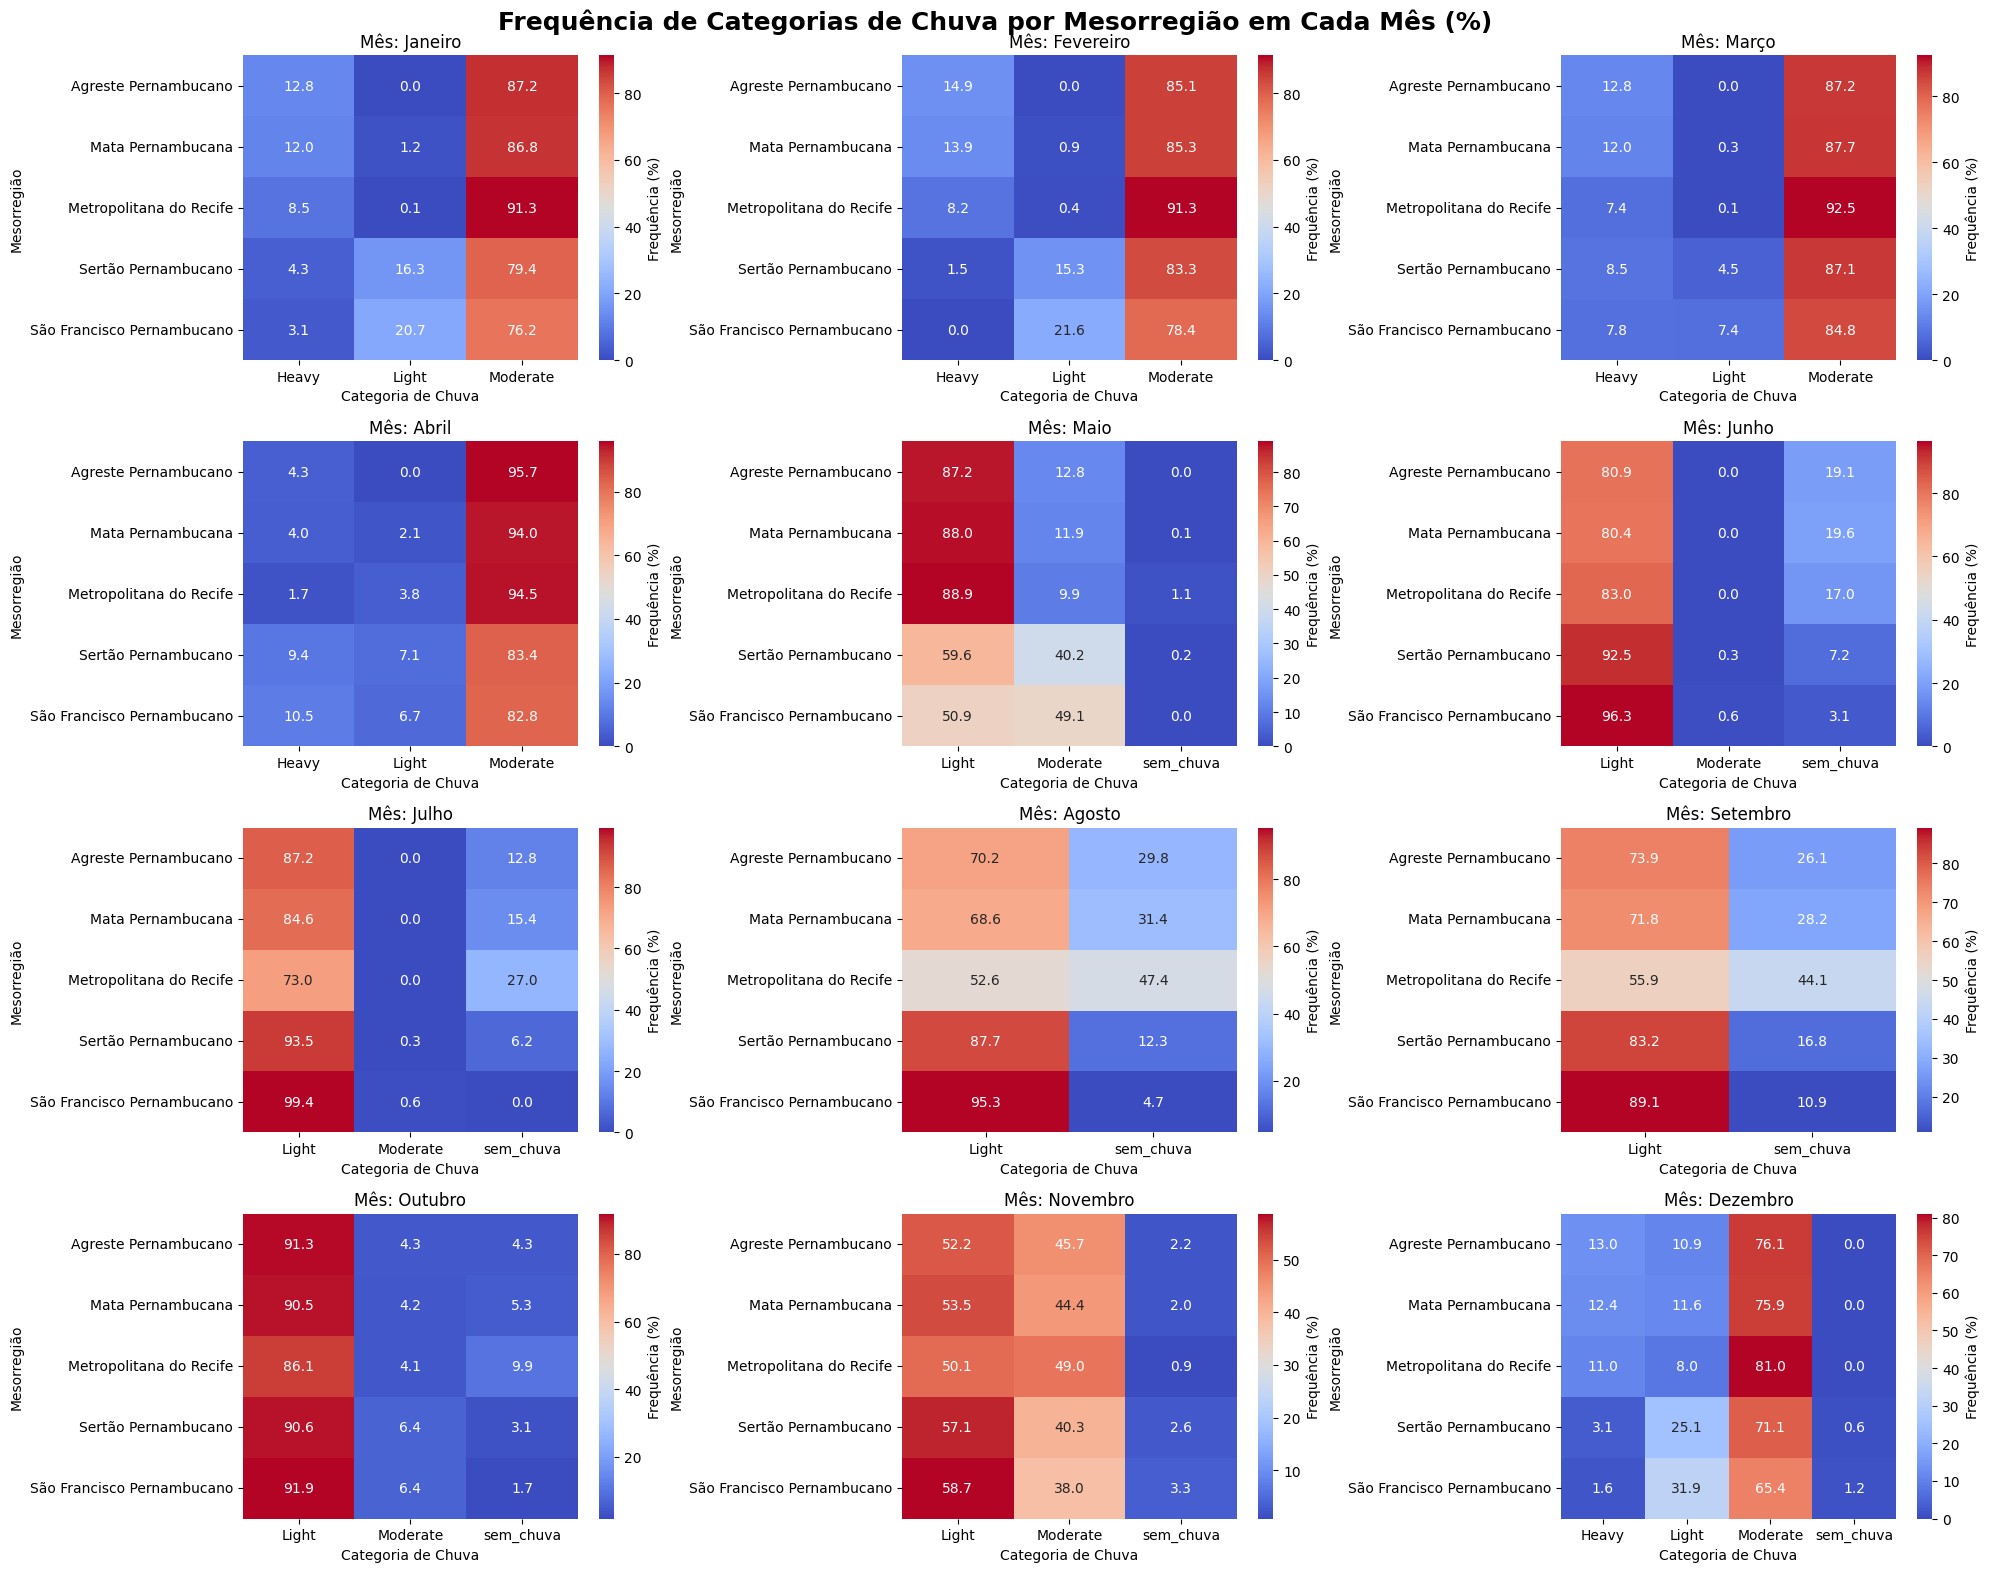

In [48]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

for mes in range(1, 13):
    dados_mes = dados_completos[dados_completos['Mes'] == mes]
    
    freq_relativa = pd.crosstab(
        dados_mes['Mesorregião'], 
        dados_mes['Categoria_Chuva'],
        normalize='index'
    ) * 100
    
    sns.heatmap(freq_relativa, annot=True, fmt='.1f', cmap='coolwarm', 
                cbar_kws={'label': 'Frequência (%)'}, ax=axes[mes-1])
    axes[mes-1].set_title(f'Mês: {nomes_meses[mes]}')
    axes[mes-1].set_xlabel('Categoria de Chuva')
    axes[mes-1].set_ylabel('Mesorregião')

plt.suptitle('Frequência de Categorias de Chuva por Mesorregião em Cada Mês (%)', 
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

## Distribuição por trimestre do ano

Distribuição de chuva por trimestre

In [49]:
media_trimestre = (
    dados_completos.groupby(['Mesorregião', 'Trimestre'])['Precipitacao_mm_mes']
    .mean()
    .reset_index()
    )

media_trimestre['Trimestre'] = pd.Categorical(media_trimestre['Trimestre'], categories=ordem_trimestres, ordered=True)
media_trimestre = media_trimestre.sort_values('Trimestre')

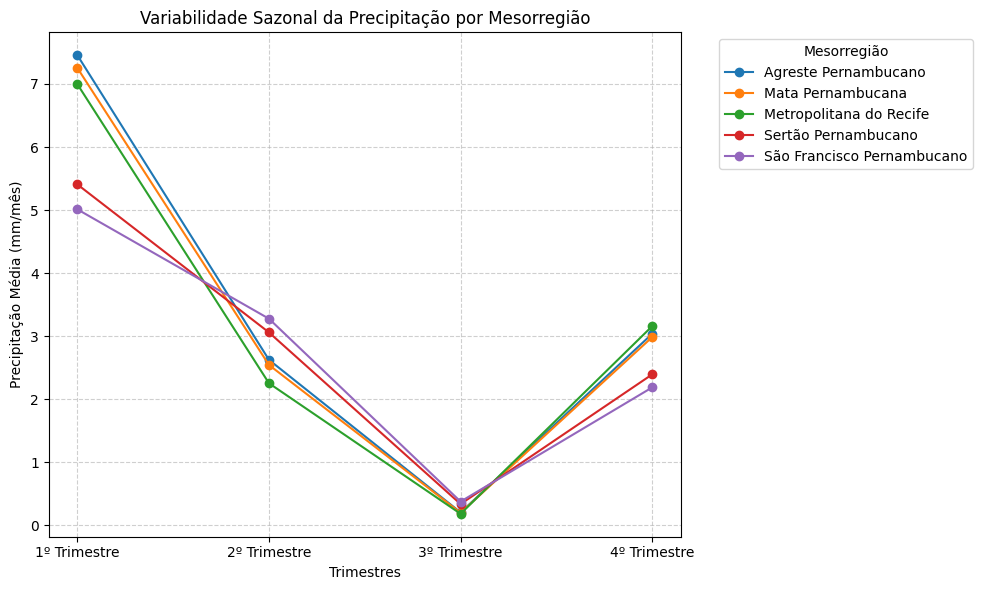

In [50]:
plt.figure(figsize=(10, 6))
for mesorregiao, grupo in media_trimestre.groupby('Mesorregião'):
    plt.plot(grupo['Trimestre'], grupo['Precipitacao_mm_mes'], marker='o', label=mesorregiao)
plt.title('Variabilidade Sazonal da Precipitação por Mesorregião')
plt.xlabel('Trimestres')
plt.ylabel('Precipitação Média (mm/mês)')
plt.legend(title='Mesorregião', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Testes

### teste de normalidade e homogeneidade trimestre

Fiz o teste de normalidade e plotei o gráfico que mostra a normalidade por trimestre a cada mesorregião

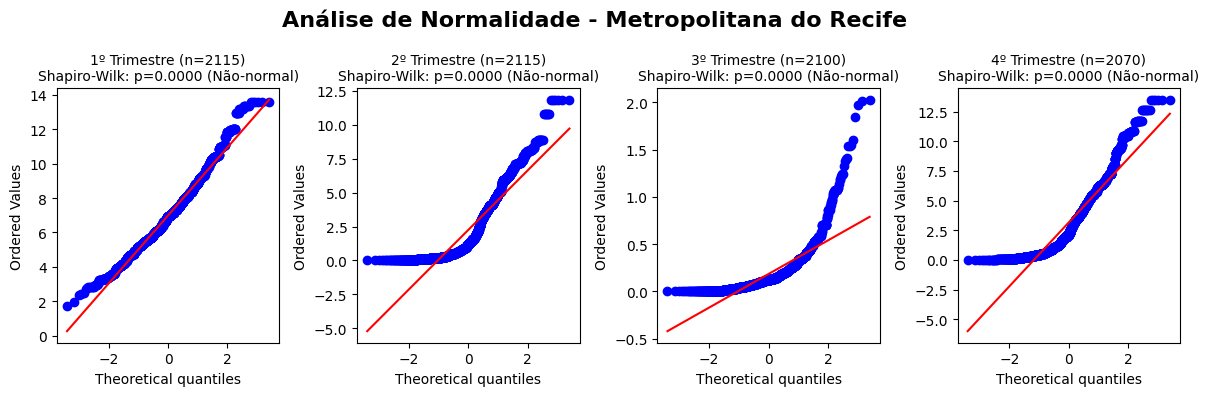

c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5781.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5740.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5658.
  res = hypotest_fun_out(*samples, **kwds)


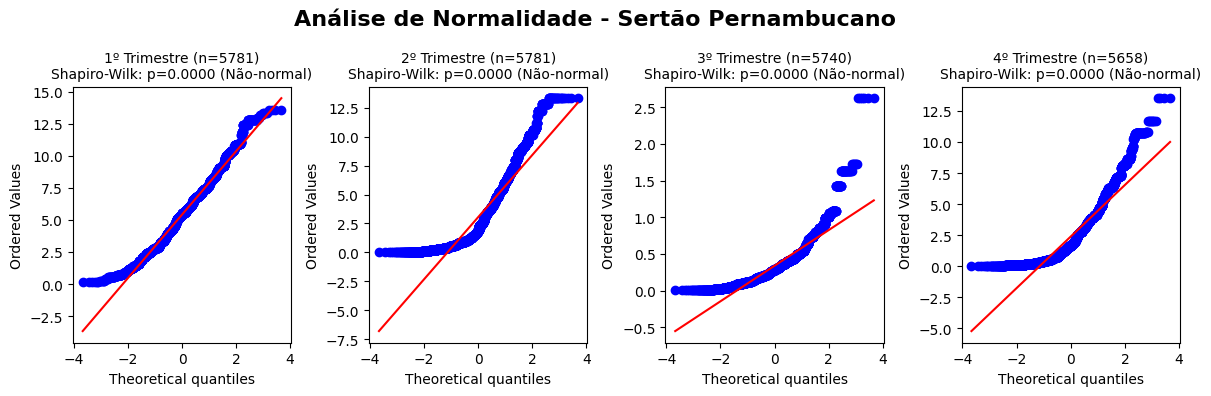

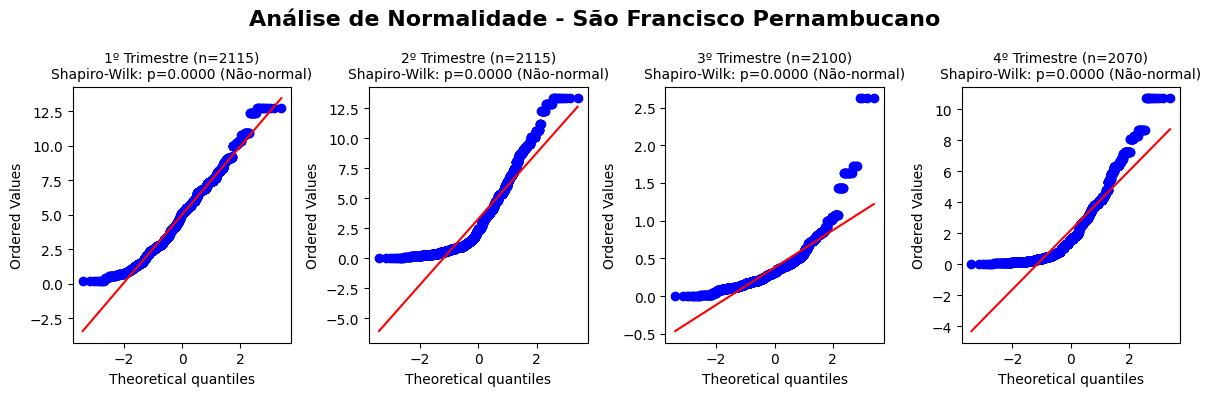

c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10011.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9940.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9798.
  res = hypotest_fun_out(*samples, **kwds)


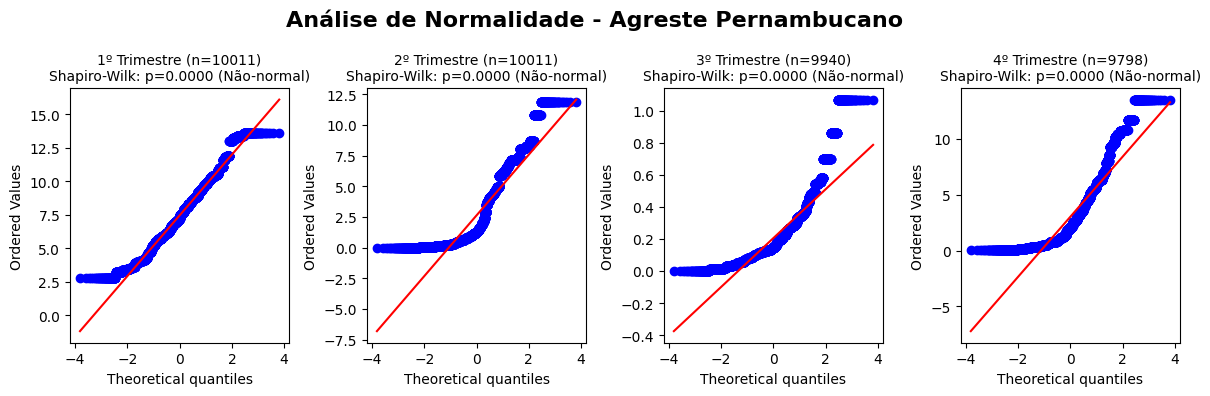

c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6063.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6020.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5934.
  res = hypotest_fun_out(*samples, **kwds)


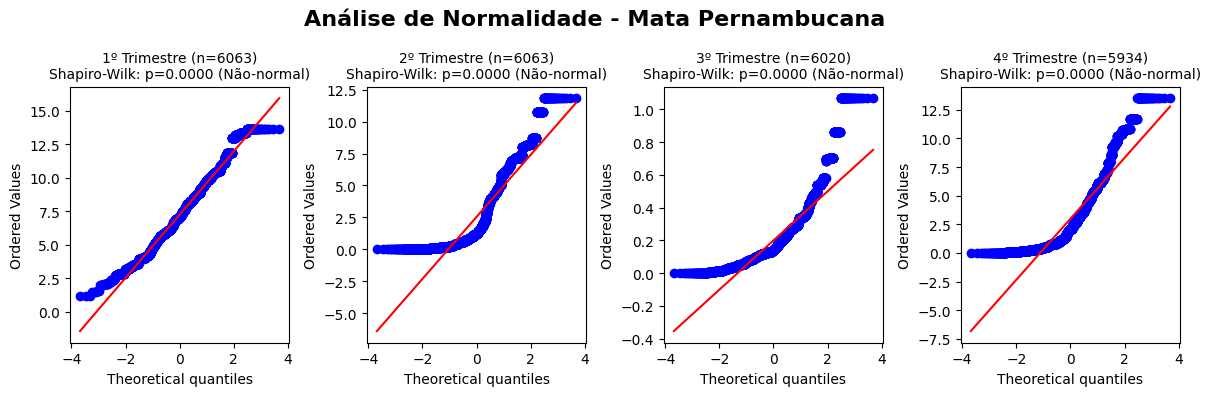

In [51]:
for meso in mesorregioes:
    n_estacoes = len(ordem_trimestres)
    cols = 4
    rows = (n_estacoes + cols - 1) // cols
    
    plt.figure(figsize=(12, 4 * rows))
    plt.suptitle(f'Análise de Normalidade - {meso}', fontsize=16, fontweight='bold')
    
    for j, trimestre in enumerate(ordem_trimestres):
        plt.subplot(rows, cols, j + 1)
        
        dados_filtrados = dados_completos[
            (dados_completos['Mesorregião'] == meso) & 
            (dados_completos['Trimestre'] == trimestre)
        ]['Precipitacao_mm_mes'].dropna()
        
        if len(dados_filtrados) > 0:
            stats.probplot(dados_filtrados, dist="norm", plot=plt)
            
            stat_sw, p_sw = stats.shapiro(dados_filtrados)
            normalidade = "Normal" if p_sw > 0.05 else "Não-normal"
            
            plt.title(f'{trimestre} (n={len(dados_filtrados)})\nShapiro-Wilk: p={p_sw:.4f} ({normalidade})', 
                     fontsize=10)
        else:
            plt.text(0.5, 0.5, 'Sem dados', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f'{trimestre}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

Fiz o Teste de Levene para verificar o Homocedasticidade dos dados

In [52]:
for trimestre in ordem_trimestres:
    print(f"\nEstação: {trimestre}")
    
    grupos_estacao = []
    for meso in mesorregioes:
        dados_trimestre = dados_completos[
            (dados_completos['Mesorregião'] == meso) & 
            (dados_completos['Trimestre'] == trimestre)
        ]['Precipitacao_mm_mes'].dropna()
        grupos_estacao.append(dados_trimestre)
    
    grupos_validos = [grupo for grupo in grupos_estacao if len(grupo) > 1]
    mesorregioes_validas = [meso for meso, grupo in zip(mesorregioes, grupos_estacao) if len(grupo) > 1]
    
    if len(grupos_validos) >= 2:
        stat_levene, p_levene = stats.levene(*grupos_validos)
        print(f"Teste de Levene:")
        print(f"  Estatística: {stat_levene:.4f}")
        print(f"  P-Valor: {p_levene:.4f}")
        
        if p_levene > 0.05:
            print("Homocedasticidade (variâncias iguais)")
        else:
            print("Heterocedasticidade (variâncias diferentes)")
        
    else:
        print("  Dados insuficientes para testes estatísticos")


Estação: 1º Trimestre
Teste de Levene:
  Estatística: 48.9057
  P-Valor: 0.0000
Heterocedasticidade (variâncias diferentes)

Estação: 2º Trimestre
Teste de Levene:
  Estatística: 20.2733
  P-Valor: 0.0000
Heterocedasticidade (variâncias diferentes)

Estação: 3º Trimestre
Teste de Levene:
  Estatística: 244.5952
  P-Valor: 0.0000
Heterocedasticidade (variâncias diferentes)

Estação: 4º Trimestre
Teste de Levene:
  Estatística: 109.3324
  P-Valor: 0.0000
Heterocedasticidade (variâncias diferentes)


In [53]:
# conclusão: ocê tem forte evidência estatística para concluir que as mesorregiões 
# geográficas de Pernambuco NÃO são equivalentes em termos de volume médio de precipitação

### teste de normalidade e homogenidade por mês

Repetindo a mesma coisa por mês

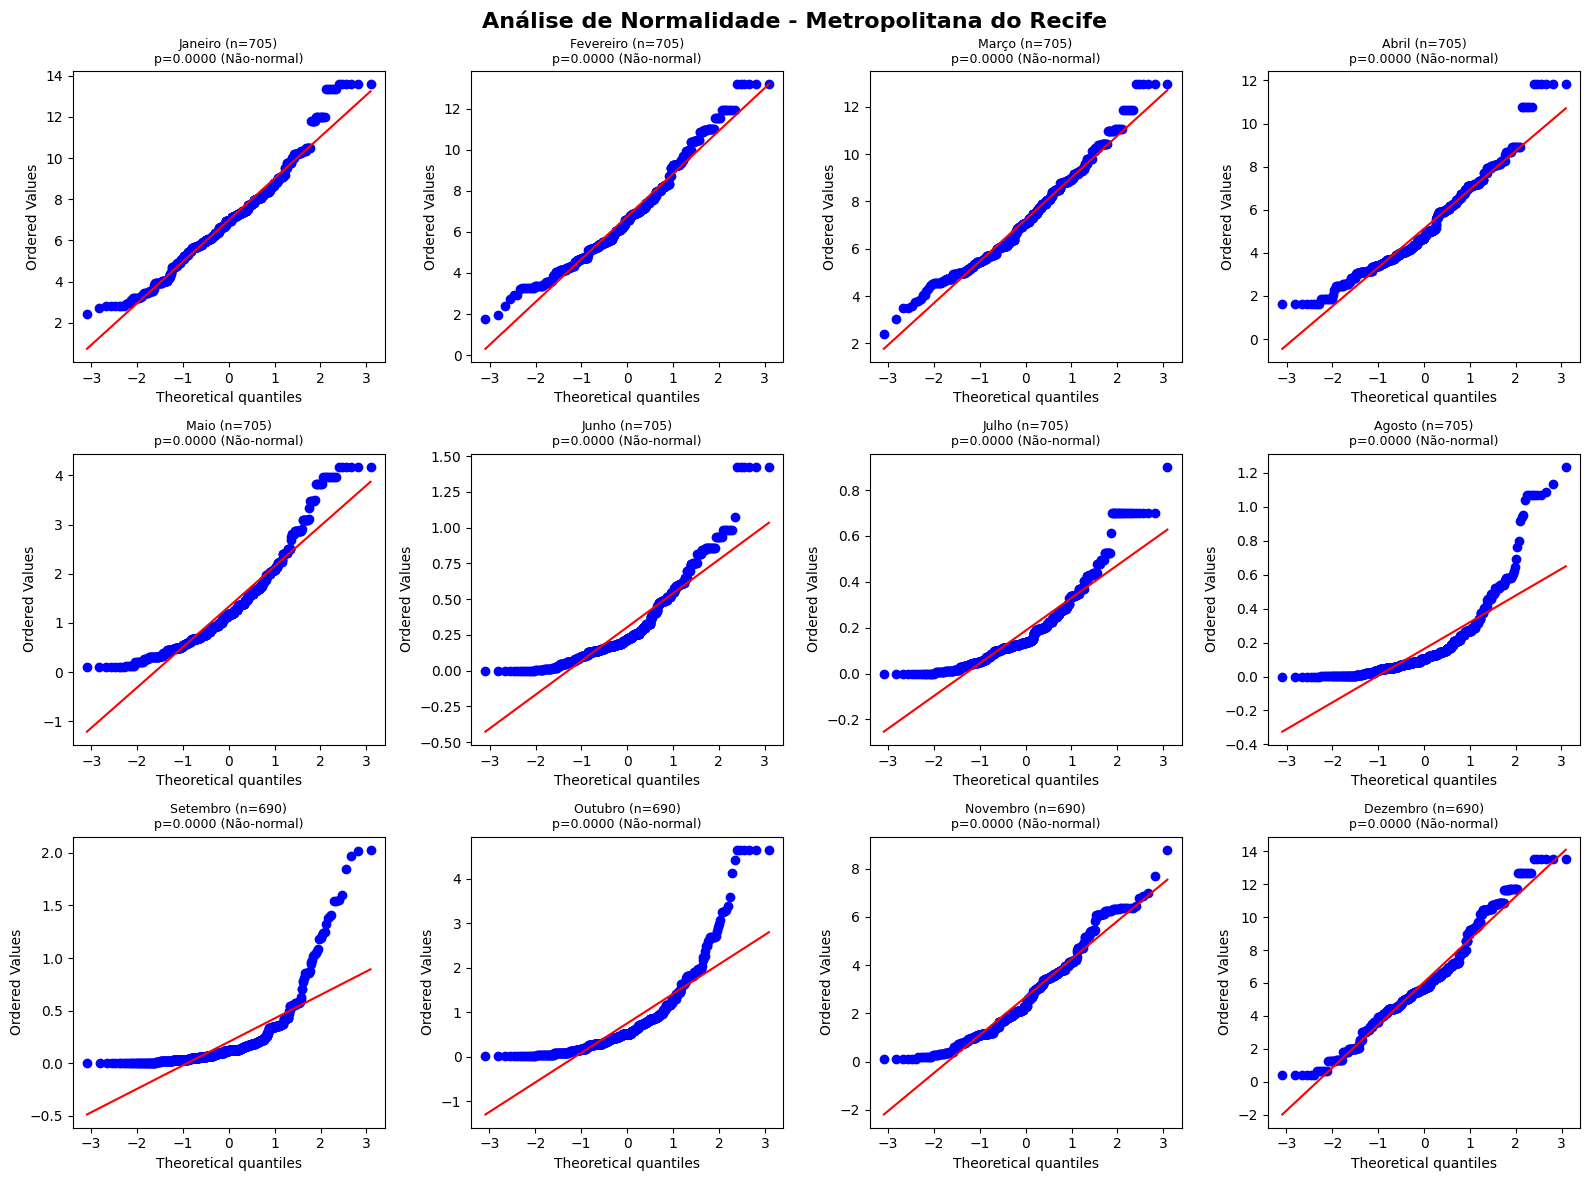

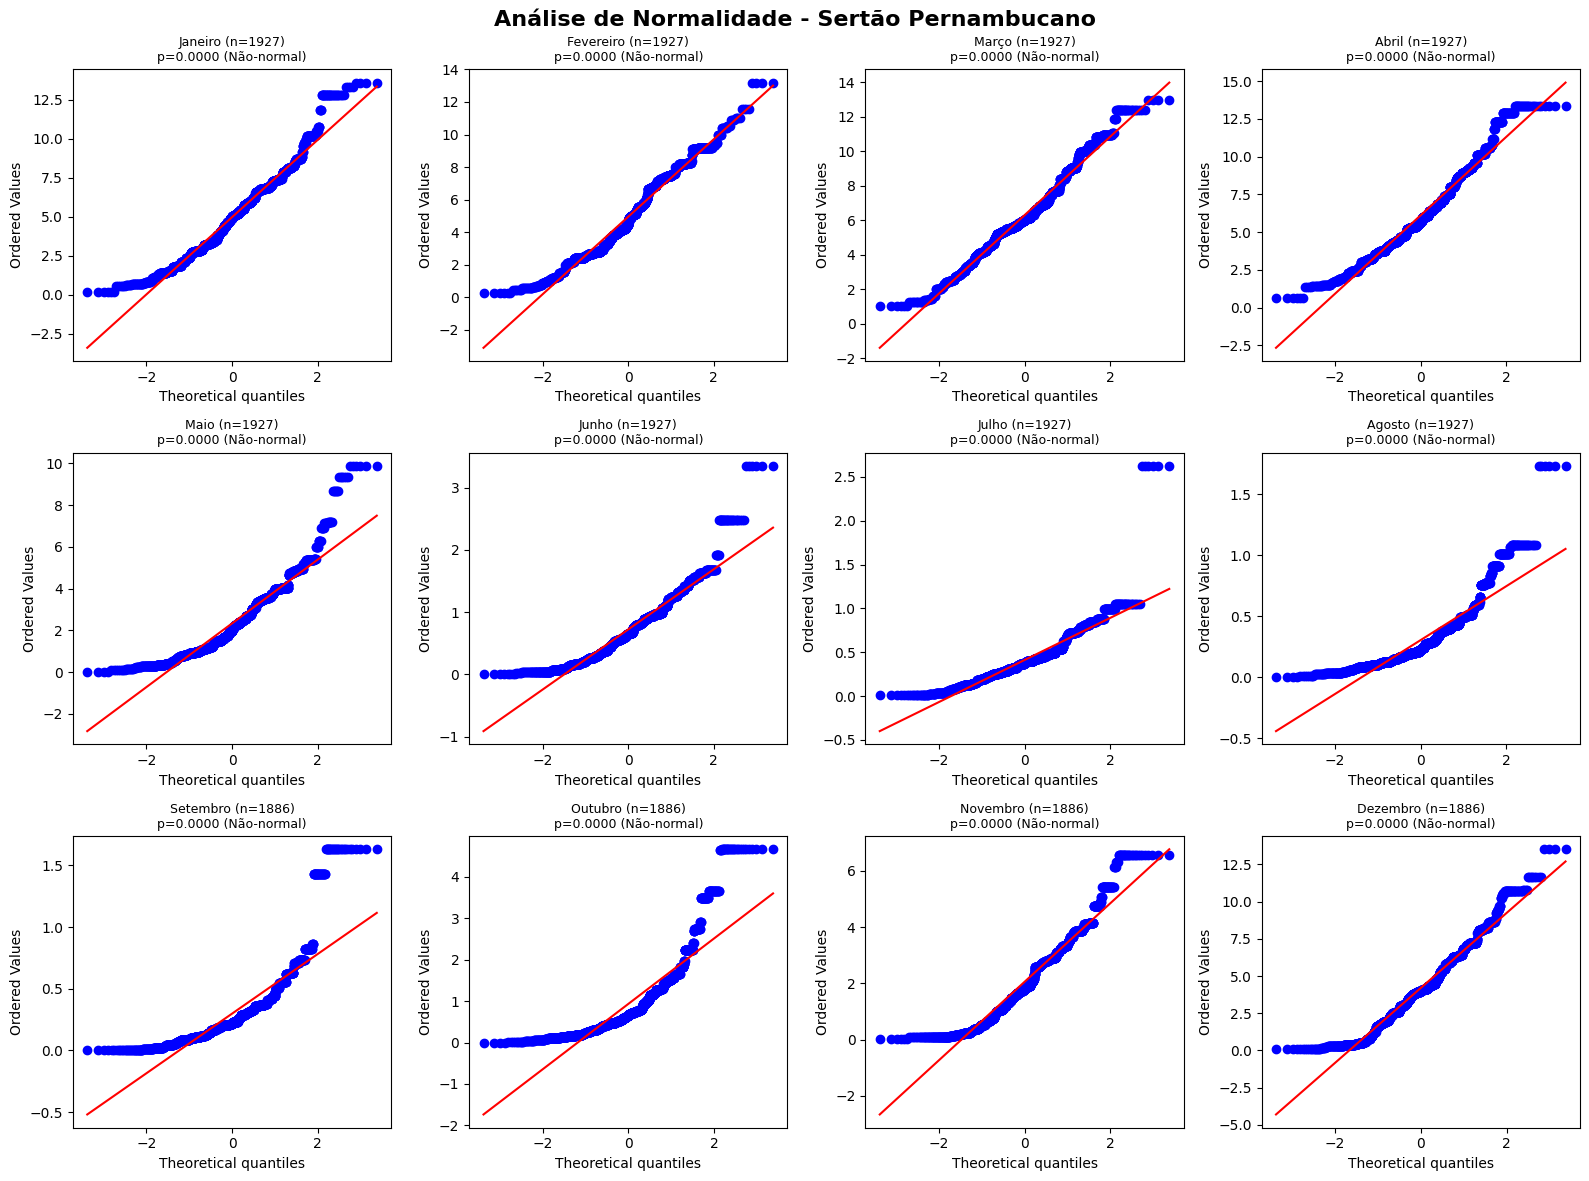

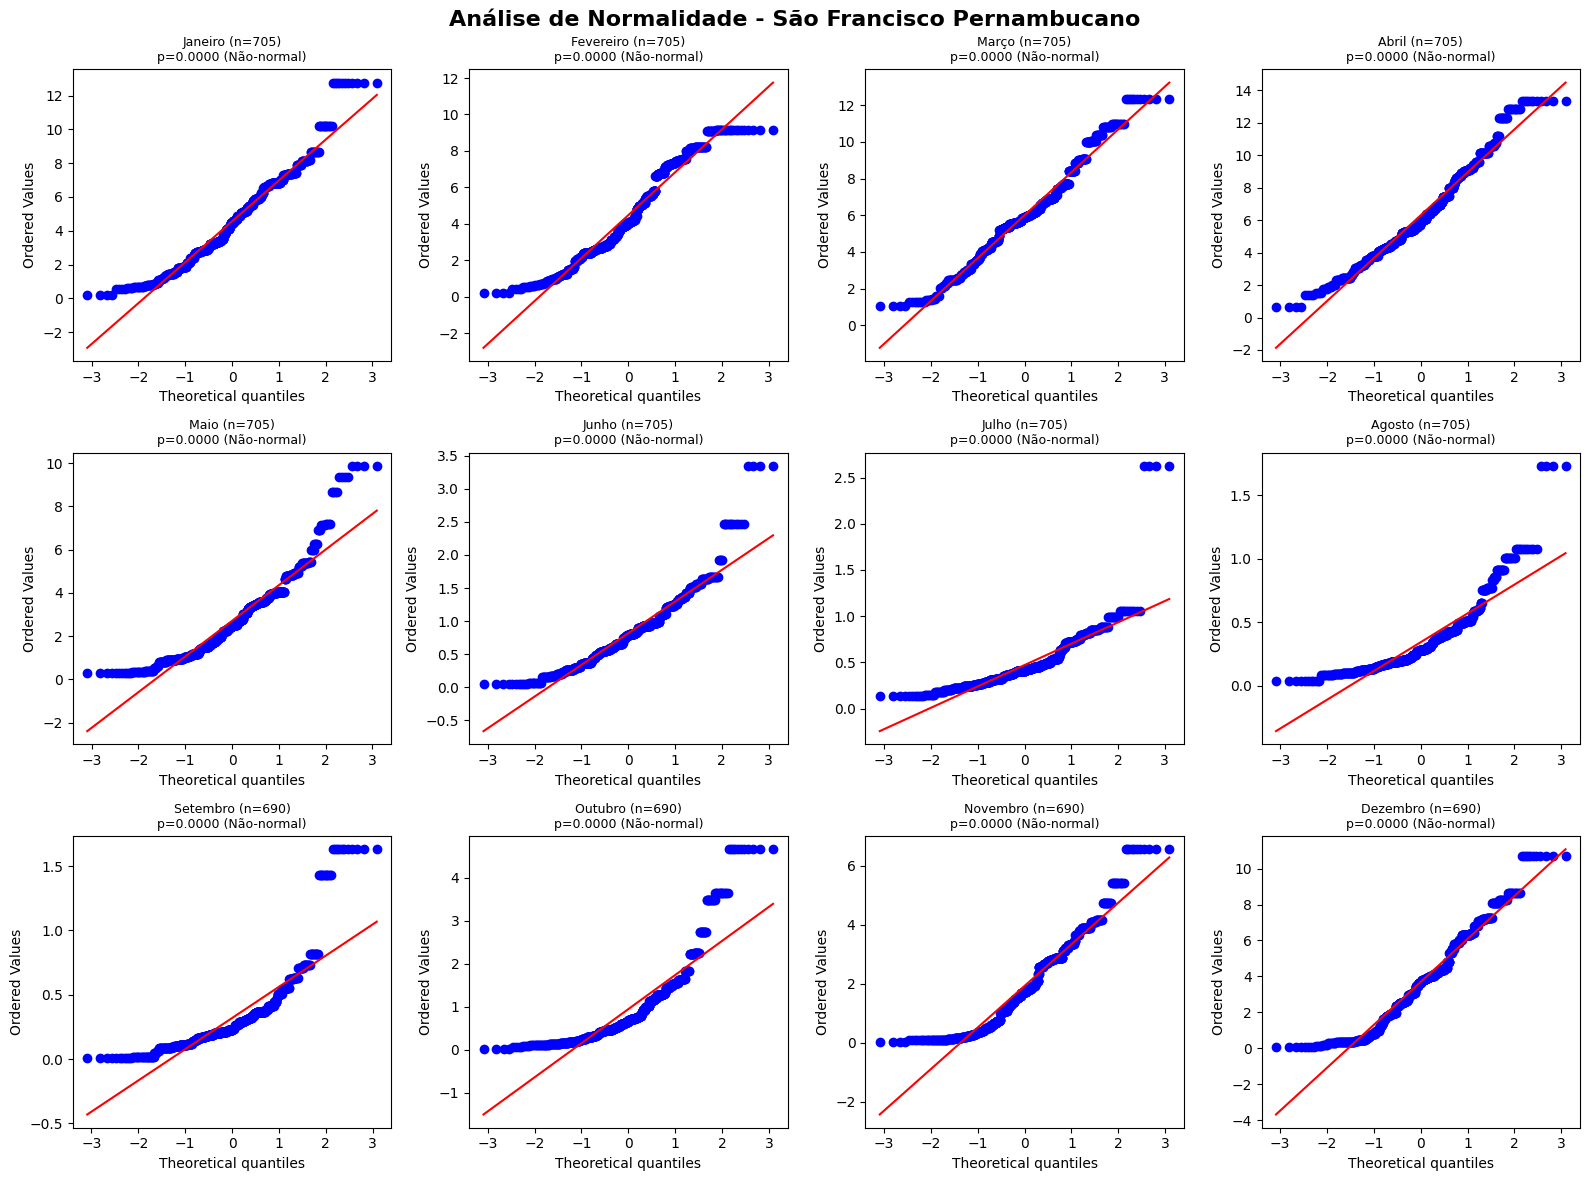

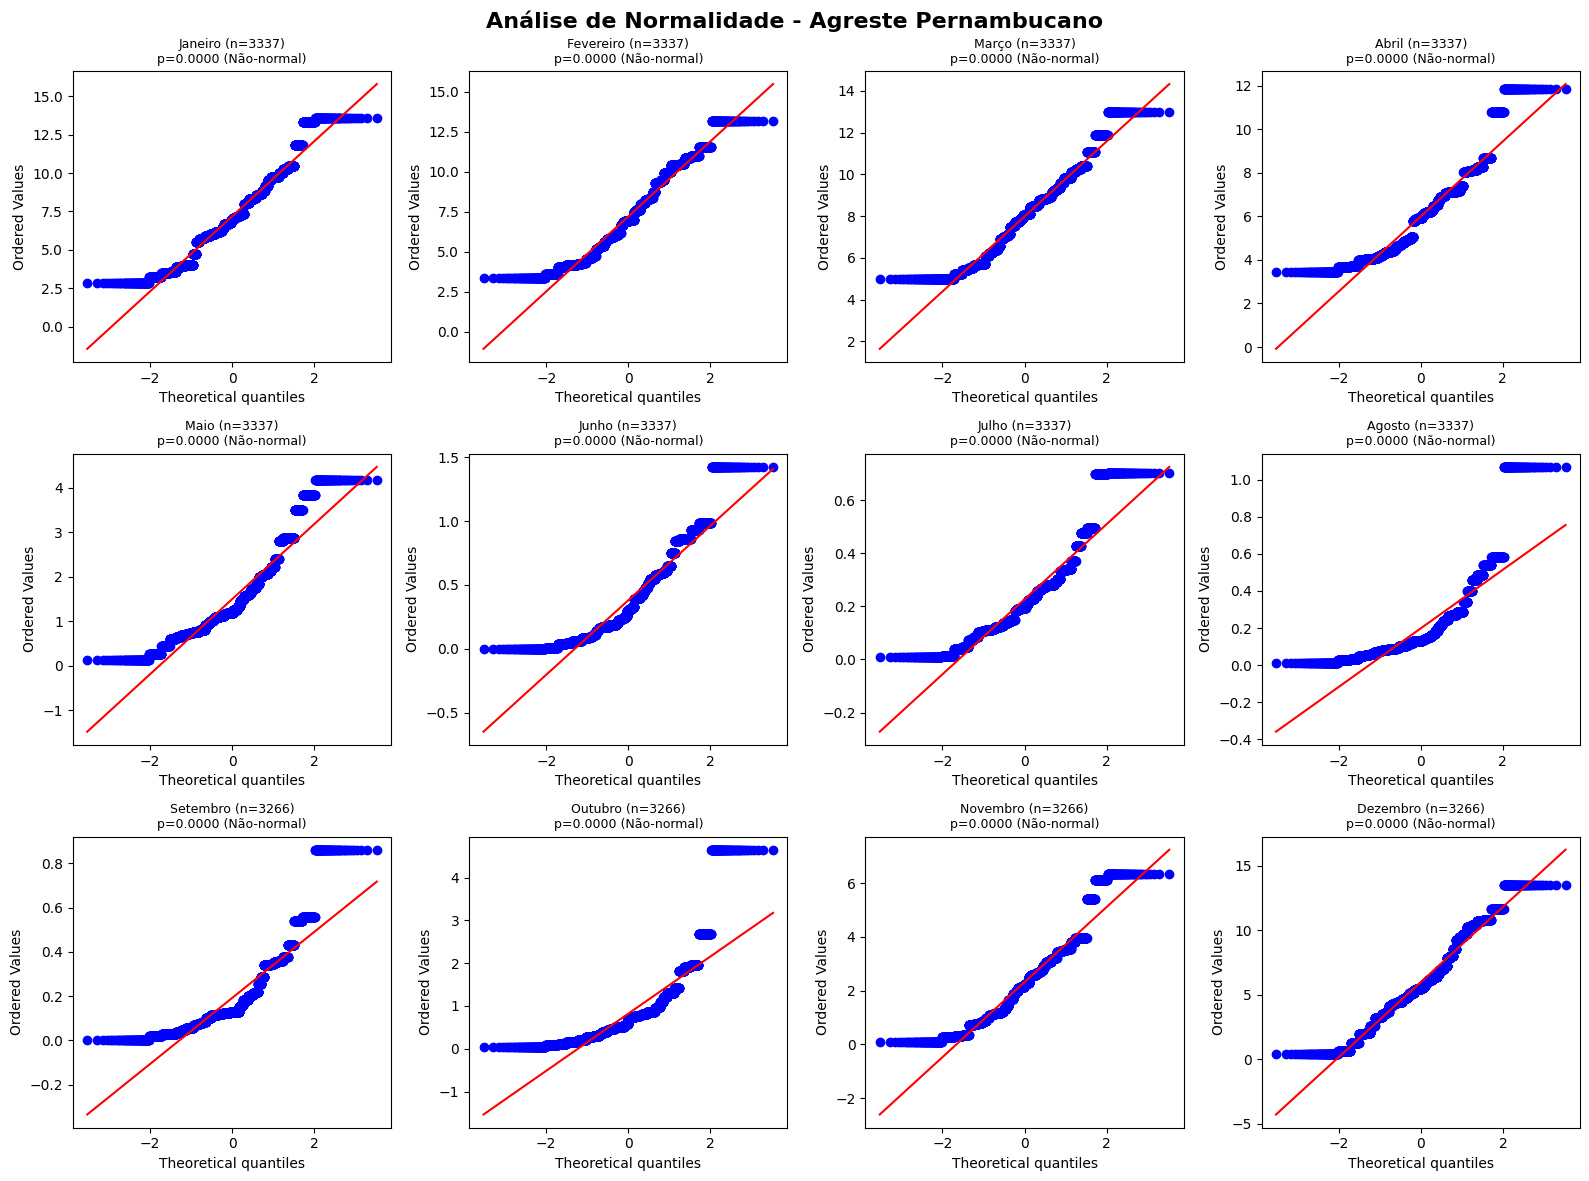

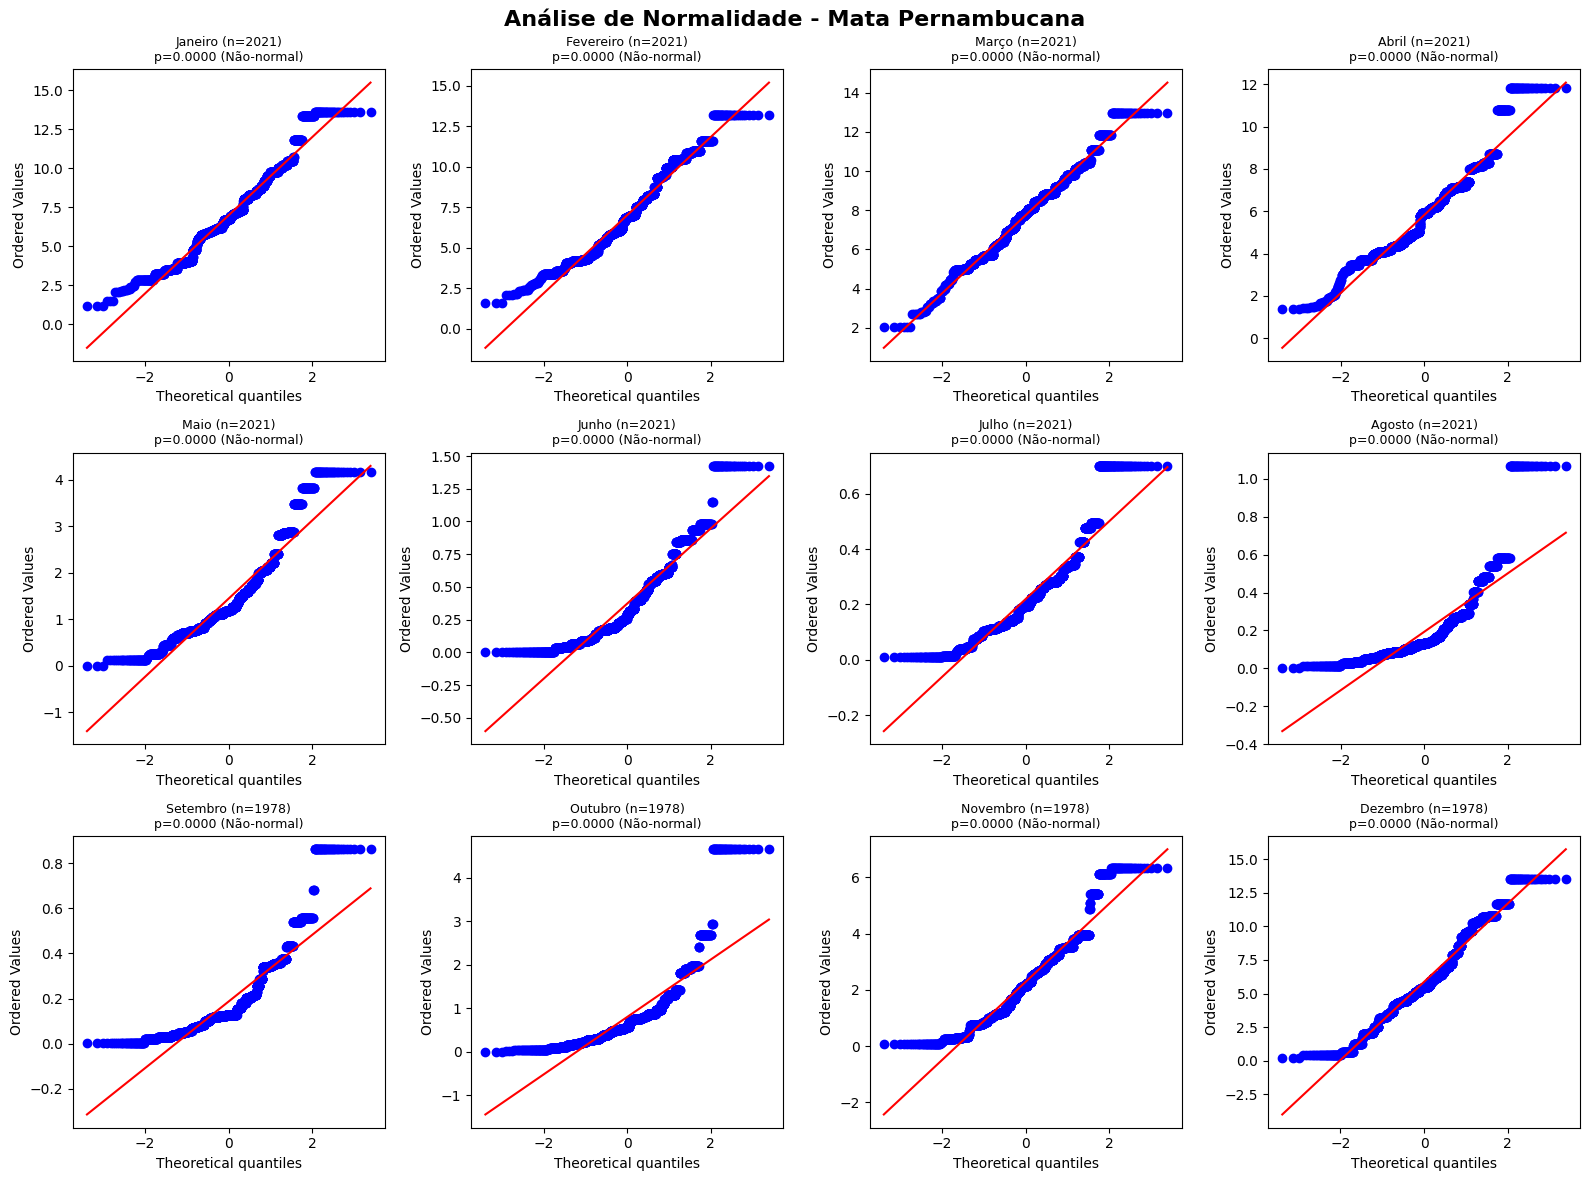

In [54]:
for meso in mesorregioes:
    n_meses = 12
    cols = 4 
    rows = (n_meses + cols - 1) // cols 
    
    plt.figure(figsize=(16, 4 * rows))
    plt.suptitle(f'Análise de Normalidade - {meso}', fontsize=16, fontweight='bold')
    
    for mes in range(1, 13):
        plt.subplot(rows, cols, mes)
        
        # Filtrar dados
        dados_filtrados = dados_completos[
            (dados_completos['Mesorregião'] == meso) & 
            (dados_completos['Mes'] == mes)
        ]['Precipitacao_mm_mes'].dropna()
        
        if len(dados_filtrados) > 0:
            stats.probplot(dados_filtrados, dist="norm", plot=plt)
            
            stat_sw, p_sw = stats.shapiro(dados_filtrados)
            normalidade = "Normal" if p_sw > 0.05 else "Não-normal"
            
            plt.title(f'{nomes_meses[mes]} (n={len(dados_filtrados)})\np={p_sw:.4f} ({normalidade})', 
                     fontsize=9)
        else:
            plt.text(0.5, 0.5, 'Sem dados', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=10)
            plt.title(f'{nomes_meses[mes]}', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [55]:
for mes in range(1, 13):
    nome_mes = nomes_meses[mes]
    print(f"\n--- Mês: {nome_mes} ---")
    
    grupos_mes = []
    
    for meso in dados_completos['Mesorregião'].unique(): 
        dados_mes = dados_completos[
            (dados_completos['Mesorregião'] == meso) & 
            (dados_completos['Mes'] == mes) 
        ]['Precipitacao_mm_mes'].dropna()
        grupos_mes.append(dados_mes)
    
    grupos_validos = [grupo for grupo in grupos_mes if len(grupo) > 1]
    
    if len(grupos_validos) >= 2:
        try:
            stat_levene, p_levene = stats.levene(*grupos_validos)
            print(f"Teste de Levene:")
            print(f"  Estatística: {stat_levene:.4f}")
            print(f"  P-Valor: {p_levene:.4f}")
            
            if p_levene > 0.05:
                print("Resultado: Homocedasticidade (Variâncias iguais).")
            else:
                print("Resultado: Heterocedasticidade (Variâncias diferentes).")
        
        except ValueError:
            print("Dados insuficientes/inválidos para rodar o Teste de Levene.")
            
    else:
        print("Dados insuficientes para testes estatísticos (menos de 2 mesorregiões com n>1).")


--- Mês: Janeiro ---
Teste de Levene:
  Estatística: 13.3731
  P-Valor: 0.0000
Resultado: Heterocedasticidade (Variâncias diferentes).

--- Mês: Fevereiro ---
Teste de Levene:
  Estatística: 10.8167
  P-Valor: 0.0000
Resultado: Heterocedasticidade (Variâncias diferentes).

--- Mês: Março ---
Teste de Levene:
  Estatística: 22.1806
  P-Valor: 0.0000
Resultado: Heterocedasticidade (Variâncias diferentes).

--- Mês: Abril ---
Teste de Levene:
  Estatística: 106.3646
  P-Valor: 0.0000
Resultado: Heterocedasticidade (Variâncias diferentes).

--- Mês: Maio ---
Teste de Levene:
  Estatística: 269.7759
  P-Valor: 0.0000
Resultado: Heterocedasticidade (Variâncias diferentes).

--- Mês: Junho ---
Teste de Levene:
  Estatística: 175.4531
  P-Valor: 0.0000
Resultado: Heterocedasticidade (Variâncias diferentes).

--- Mês: Julho ---
Teste de Levene:
  Estatística: 109.0211
  P-Valor: 0.0000
Resultado: Heterocedasticidade (Variâncias diferentes).

--- Mês: Agosto ---
Teste de Levene:
  Estatística: 

### ANOVA por trimestre

O teste de ANOVA por trimestre para verificar se existe ou não diferenças entre as mesorregiões olhando por trimestre 

In [56]:
for trimestre in ordem_trimestres:
    dados_trimestre = dados_completos[dados_completos['Trimestre'] == trimestre].copy()
        
    contagens = dados_trimestre['Mesorregião'].value_counts()
    mesorregioes_validas = contagens[contagens >= 2].index
    
    dados_trimestre = dados_trimestre[dados_trimestre['Mesorregião'].isin(mesorregioes_validas)].dropna(
        subset=['Precipitacao_mm_mes', 'Mesorregião']
    )
    
    num_mesorregioes = dados_trimestre['Mesorregião'].nunique()
    
    if num_mesorregioes < 2:
        print(f"\n*** {trimestre}: Dados insuficientes (menos de 2 mesorregiões com dados válidos).")
        continue

    print(f"\n*** {trimestre} (Comparando {num_mesorregioes} mesorregiões) ***")

    try:
        modelo = ols('Precipitacao_mm_mes ~ C(Mesorregião)', data=dados_trimestre).fit()
        anova_tabela = sm.stats.anova_lm(modelo, typ=2)
        
        print(anova_tabela)

    except ValueError as e:
        print(f"Erro ao rodar ANOVA para {trimestre}: {e}")


*** 1º Trimestre (Comparando 5 mesorregiões) ***
                       sum_sq       df            F  PR(>F)
C(Mesorregião)   23435.852700      4.0  1066.541442     0.0
Residual        143268.469052  26080.0          NaN     NaN

*** 2º Trimestre (Comparando 5 mesorregiões) ***
                       sum_sq       df          F        PR(>F)
C(Mesorregião)    2060.307002      4.0  69.210044  2.195401e-58
Residual        194093.238489  26080.0        NaN           NaN

*** 3º Trimestre (Comparando 5 mesorregiões) ***
                     sum_sq       df           F  PR(>F)
C(Mesorregião)   122.654241      4.0  718.031844     0.0
Residual        1105.846349  25895.0         NaN     NaN

*** 4º Trimestre (Comparando 5 mesorregiões) ***
                       sum_sq       df          F        PR(>F)
C(Mesorregião)    2718.729608      4.0  93.185428  8.163886e-79
Residual        186176.033477  25525.0        NaN           NaN


### ANOVA por Mês

O teste de ANOVA por trimestre para verificar se existe ou não diferenças entre as mesorregiões olhando por mês 

In [57]:
for mes in range(1, 13):
    nome_mes = nomes_meses[mes]
    
    dados_mes = dados_completos[dados_completos['Mes'] == mes].copy()
    
    #verifica se existe dados suficientes 
    contagens = dados_mes['Mesorregião'].value_counts()
    mesorregioes_validas = contagens[contagens >= 2].index
    
    dados_mes = dados_mes[dados_mes['Mesorregião'].isin(mesorregioes_validas)].dropna(
        subset=['Precipitacao_mm_mes', 'Mesorregião']
    )

    num_mesorregioes = dados_mes['Mesorregião'].nunique()
    if num_mesorregioes < 2:
        print(f"\n{nome_mes}: Dados insuficientes (menos de 2 mesorregiões com dados).")
        continue

    print(f"\n*** {nome_mes} (Comparando {num_mesorregioes} mesorregiões) ***")

    # ANOVA
    try:
        modelo = ols('Precipitacao_mm_mes ~ C(Mesorregião)', data=dados_mes).fit()
        anova_tabela = sm.stats.anova_lm(modelo, typ=2)
        
        p_anova = anova_tabela['PR(>F)']['C(Mesorregião)']
        
        #print(f"P-valor ANOVA: {p_anova:.4f}")
        
        # Interpretação
        alpha = 0.05
        # if p_anova < alpha:
        #     print("Resultado: REJEITA H0. Há diferença estatística significativa na média de precipitação entre as mesorregiões neste mês.")
        # else:
        #     print("Resultado: NÃO REJEITA H0. Não há evidência de diferença estatística na média de precipitação entre as mesorregiões neste mês.")
            
        print(anova_tabela)
    except ValueError as e:
        print(f"Erro ao rodar ANOVA para {nome_mes}: {e}")


*** Janeiro (Comparando 5 mesorregiões) ***
                      sum_sq      df           F         PR(>F)
C(Mesorregião)   9287.557681     4.0  381.655182  2.593682e-303
Residual        52867.666989  8690.0         NaN            NaN

*** Fevereiro (Comparando 5 mesorregiões) ***
                      sum_sq      df           F  PR(>F)
C(Mesorregião)   9681.725754     4.0  424.877141     0.0
Residual        49505.014891  8690.0         NaN     NaN

*** Março (Comparando 5 mesorregiões) ***
                      sum_sq      df           F         PR(>F)
C(Mesorregião)   5083.298280     4.0  312.357998  1.750079e-251
Residual        35355.155295  8690.0         NaN            NaN

*** Abril (Comparando 5 mesorregiões) ***
                      sum_sq      df          F        PR(>F)
C(Mesorregião)    667.061379     4.0  37.333906  5.239279e-31
Residual        38817.016030  8690.0        NaN           NaN

*** Maio (Comparando 5 mesorregiões) ***
                      sum_sq      df   

## Teste de Tukey

Verifica quais regiões são comuns entre si

In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### por trimestre

faz verificação por trimestre

In [59]:
for trimestre in ordem_trimestres:
    print(f"\n{'='*50}")
    print(f"ESTAÇÃO: {trimestre.upper()}")
    print(f"{'='*50}")
    
    # Filtrar dados da estação
    dados_trimestre = dados_completos[dados_completos['Trimestre'] == trimestre]
    
    if len(dados_trimestre) > 0:
        tukey_estacao = pairwise_tukeyhsd(
            endog=dados_trimestre['Precipitacao_mm_mes'],
            groups=dados_trimestre['Mesorregião'],
            alpha=0.05
        )
        print(tukey_estacao)
            
        print(f"\n--- ESTATÍSTICAS em {trimestre} ---")
        stats_estacao = dados_trimestre.groupby('Mesorregião')['Precipitacao_mm_mes'].agg([
            'count', 'mean', 'std'
        ]).round(3)
        print(stats_estacao)
        
    else:
        print("  Sem dados para esta estação")


ESTAÇÃO: 1º TRIMESTRE
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1                   group2           meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------
   Agreste Pernambucano          Mata Pernambucana  -0.2019    0.0 -0.3059 -0.0978   True
   Agreste Pernambucano    Metropolitana do Recife  -0.4593    0.0 -0.6123 -0.3063   True
   Agreste Pernambucano        Sertão Pernambucano  -2.0483    0.0 -2.1539 -1.9427   True
   Agreste Pernambucano São Francisco Pernambucano  -2.4434    0.0 -2.5964 -2.2904   True
      Mata Pernambucana    Metropolitana do Recife  -0.2574 0.0001 -0.4189 -0.0959   True
      Mata Pernambucana        Sertão Pernambucano  -1.8464    0.0 -1.9639 -1.7289   True
      Mata Pernambucana São Francisco Pernambucano  -2.2416    0.0  -2.403 -2.0801   True
Metropolitana do Recife        Sertão Pernambucano   -1.589    0.0 -1.7515 -1

### por mês

faz verificação por mÊs

In [60]:
nomes_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}


for mes in range(1, 13):
    print(f"\n{'='*50}")
    print(f"MÊS: {nomes_meses[mes].upper()}")
    print(f"{'='*50}")
    
    dados_mes = dados_completos[dados_completos['Mes'] == mes]
    
    if len(dados_mes) > 0:
        # Teste Tukey HSD
        tukey_mes = pairwise_tukeyhsd(
            endog=dados_mes['Precipitacao_mm_mes'],
            groups=dados_mes['Mesorregião'],
            alpha=0.05
        )
        print(tukey_mes)
        
        print(f"\n--- ESTATÍSTICAS em {nomes_meses[mes]} ---")
        stats_mes = dados_mes.groupby('Mesorregião')['Precipitacao_mm_mes'].agg([
            'count', 'mean', 'std'
        ]).round(3)
        print(stats_mes)


MÊS: JANEIRO
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1                   group2           meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------
   Agreste Pernambucano          Mata Pernambucana  -0.1807 0.0706 -0.3704   0.009  False
   Agreste Pernambucano    Metropolitana do Recife  -0.1858 0.3636 -0.4647  0.0932  False
   Agreste Pernambucano        Sertão Pernambucano  -2.2009    0.0 -2.3935 -2.0084   True
   Agreste Pernambucano São Francisco Pernambucano  -2.6236    0.0 -2.9025 -2.3447   True
      Mata Pernambucana    Metropolitana do Recife  -0.0051    1.0 -0.2994  0.2893  False
      Mata Pernambucana        Sertão Pernambucano  -2.0202    0.0 -2.2345  -1.806   True
      Mata Pernambucana São Francisco Pernambucano  -2.4429    0.0 -2.7372 -2.1485   True
Metropolitana do Recife        Sertão Pernambucano  -2.0152    0.0 -2.3114  -1.719   T

In [61]:
tukey = pd.read_csv("src\Teste Tukey HSD.csv")

In [62]:
from matplotlib.lines import Line2D

mostra vizualmente quando existe uma semenhança entre as mesorregiões em um mês 

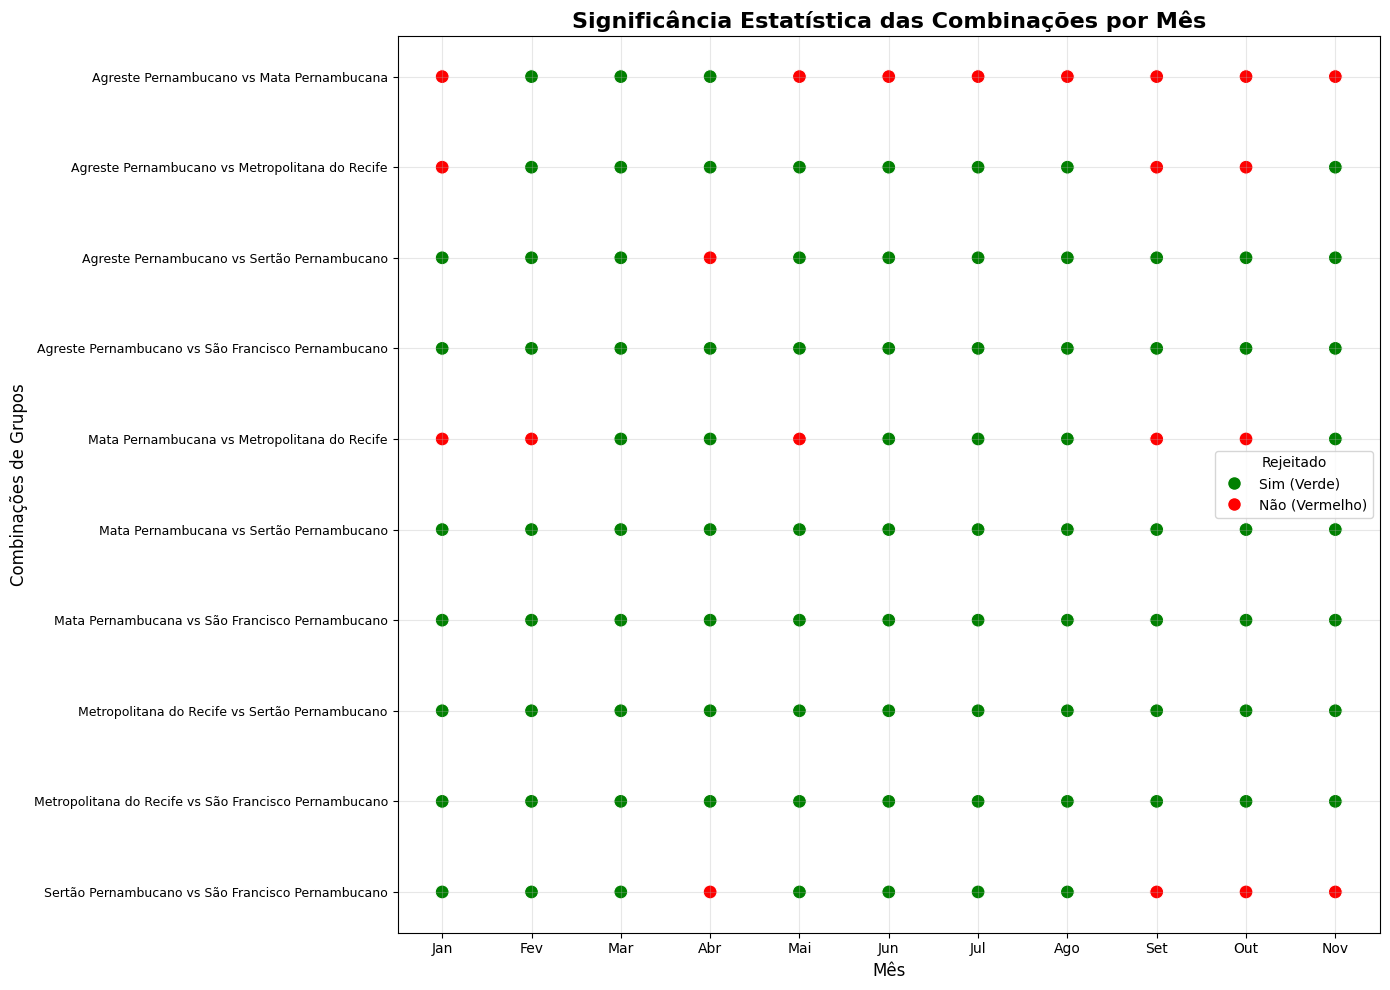

In [63]:
tukey['mês'] = tukey['mês'].astype(str)
tukey['group1'] = tukey['group1'].astype(str)
tukey['group2'] = tukey['group2'].astype(str)

tukey['combinação'] = tukey['group1'] + ' vs ' + tukey['group2']

meses_ordenados = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dec']
tukey['mês'] = pd.Categorical(tukey['mês'], categories=meses_ordenados, ordered=True)

plt.figure(figsize=(14, 10))
sns.scatterplot(data=tukey, x='mês', y='combinação', hue='reject', 
                palette={True: 'green', False: 'red'}, s=100)
plt.title('Significância Estatística das Combinações por Mês', fontsize=16, fontweight='bold')
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Combinações de Grupos', fontsize=12)
plt.yticks(fontsize=9)
plt.grid(True, alpha=0.3)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Sim (Verde)', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Não (Vermelho)', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements, title='Rejeitado', loc='best')
plt.tight_layout()
plt.show()